Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = '/home/magicz/tensorflow/workspace1/mydata/notmnist/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

logits mod with reg

In [14]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  reg_scal = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + reg_scal * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [15]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg_scal : 1.0e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 22.739794
Minibatch accuracy: 3.1%
Validation accuracy: 8.8%
Minibatch loss at step 500: 3.631526
Minibatch accuracy: 64.8%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 1.657432
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 1500: 1.258819
Minibatch accuracy: 78.9%
Validation accuracy: 79.6%
Minibatch loss at step 2000: 1.108073
Minibatch accuracy: 82.0%
Validation accuracy: 81.1%
Minibatch loss at step 2500: 0.809971
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.916817
Minibatch accuracy: 76.6%
Validation accuracy: 81.9%
Test accuracy: 88.1%


to optimize the meta para reg_scal

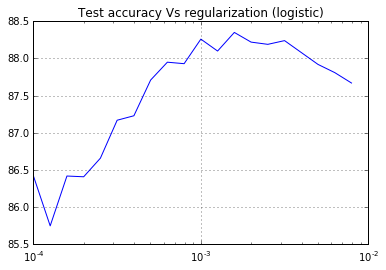

In [16]:
num_steps = 3001
reg_set = [pow(10,example) for example in np.arange(-4, -2, 0.1)]
accuracy_set = []

for reg_val in reg_set:
  with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg_scal : reg_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_set.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(reg_set, accuracy_set)
plt.grid(True)
plt.title('Test accuracy Vs regularization (logistic)')
plt.show()


neural network mod wit reg

In [27]:
def construct_layer(dataflow, weights, biases):
    return tf.add(tf.matmul(dataflow, weights), biases)

def nn_mod_reg(train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels, 
               batch_size, hidden_nodes, num_steps, reg_scal, step_print, keep_rate):
    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)
      tf_reg_scal = tf.placeholder(tf.float32)
      tf_keep_rate = tf.placeholder(tf.float32)

      # Variables.
      hidden_layer_weights = [tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes])),
                             tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))]
      hidden_layer_biases = [tf.Variable(tf.zeros([hidden_nodes])),
                            tf.Variable(tf.zeros([num_labels]))]

      # Training computation.
      hidden_layer = construct_layer(tf_train_dataset, hidden_layer_weights[0], hidden_layer_biases[0])
      hidden_layer = tf.nn.relu(hidden_layer)
      hidden_layer = tf.nn.dropout(hidden_layer, tf_keep_rate)
      logits = construct_layer(hidden_layer, hidden_layer_weights[1], hidden_layer_biases[1])
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf_reg_scal * \
        (tf.nn.l2_loss(hidden_layer_weights[0]) + tf.nn.l2_loss(hidden_layer_weights[1]))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_hidden_layer = tf.nn.relu(construct_layer(tf_valid_dataset, hidden_layer_weights[0], hidden_layer_biases[0]))
      valid_prediction = tf.nn.softmax(
          construct_layer(valid_hidden_layer,hidden_layer_weights[1],hidden_layer_biases[1]))
      test_hidden_layer = tf.nn.relu(construct_layer(tf_test_dataset, hidden_layer_weights[0], hidden_layer_biases[0]))
      test_prediction = tf.nn.softmax(
          construct_layer(test_hidden_layer,hidden_layer_weights[1],hidden_layer_biases[1]))

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, 
                    tf_reg_scal: reg_scal, tf_keep_rate: keep_rate}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_print == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
    return test_accuracy


In [28]:
batch_size_val = 128
hidden_nodes_val = 1024
num_steps_val = 3001
step_print_val = 500
reg_scal_val = 1.e-3
keep_rate_val = 1.

test_accuracy = nn_mod_reg(train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels, 
               batch_size_val, hidden_nodes_val, num_steps_val, reg_scal_val, step_print_val, keep_rate_val)
print('Test accuracy: %.1f%%' % test_accuracy)

Initialized
Minibatch loss at step 0: 627.665100
Minibatch accuracy: 9.4%
Validation accuracy: 32.7%
Minibatch loss at step 500: 204.488098
Minibatch accuracy: 67.2%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 116.747467
Minibatch accuracy: 79.7%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 69.374741
Minibatch accuracy: 81.2%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.454597
Minibatch accuracy: 87.5%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 25.259750
Minibatch accuracy: 89.8%
Validation accuracy: 86.1%
Minibatch loss at step 3000: 15.624197
Minibatch accuracy: 83.6%
Validation accuracy: 87.0%
Test accuracy: 92.6%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Minimize the training data to just a few batches while the batchsize remain unchanged.
And of course to turn off the regularization

In [14]:
batch_size_val = 128
hidden_nodes_val = 1024
num_steps_val = 201
step_print_val = 20
reg_scal_val = 0
keep_rate_val = 1.

train_data_len = 4 * batch_size_val
train_dataset_min = train_dataset[:train_data_len,:]
train_labels_min = train_labels[:train_data_len]

test_accuracy = nn_mod_reg(train_dataset_min, train_labels_min, valid_dataset, valid_labels, test_dataset, test_labels, 
               batch_size_val, hidden_nodes_val, num_steps_val, reg_scal_val, step_print_val, keep_rate_val)
print('Test accuracy: %.1f%%' % test_accuracy)

Initialized
Minibatch loss at step 0: 307.185181
Minibatch accuracy: 11.7%
Validation accuracy: 24.2%
Minibatch loss at step 20: 1.567490
Minibatch accuracy: 97.7%
Validation accuracy: 72.9%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 120: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 140: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 160: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 180: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.1%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy:

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

I'll add dropout parameter function in the definiton of Problem 1

In [15]:
batch_size_val = 128
hidden_nodes_val = 1024
num_steps_val = 201
step_print_val = 20
reg_scal_val = 0
keep_rate_val = 0.5

train_data_len = 4 * batch_size_val
train_dataset_min = train_dataset[:train_data_len,:]
train_labels_min = train_labels[:train_data_len]

test_accuracy = nn_mod_reg(train_dataset_min, train_labels_min, valid_dataset, valid_labels, test_dataset, test_labels, 
               batch_size_val, hidden_nodes_val, num_steps_val, reg_scal_val, step_print_val, keep_rate_val)
print('Test accuracy: %.1f%%' % test_accuracy)

Initialized
Minibatch loss at step 0: 434.961029
Minibatch accuracy: 10.9%
Validation accuracy: 37.4%
Minibatch loss at step 20: 21.008263
Minibatch accuracy: 91.4%
Validation accuracy: 69.4%
Minibatch loss at step 40: 1.219951
Minibatch accuracy: 98.4%
Validation accuracy: 74.3%
Minibatch loss at step 60: 5.099411
Minibatch accuracy: 96.1%
Validation accuracy: 73.6%
Minibatch loss at step 80: 0.479859
Minibatch accuracy: 98.4%
Validation accuracy: 75.4%
Minibatch loss at step 100: 0.342255
Minibatch accuracy: 99.2%
Validation accuracy: 75.1%
Minibatch loss at step 120: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 140: 0.591197
Minibatch accuracy: 98.4%
Validation accuracy: 76.1%
Minibatch loss at step 160: 0.545743
Minibatch accuracy: 99.2%
Validation accuracy: 75.5%
Minibatch loss at step 180: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.0

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Upgrade my mod based on Problem 1 with lr decay and increased depth !

In [8]:
def layer_logits(dataflow,
                 weights, 
                 biases):
    return tf.add(tf.matmul(dataflow, weights), biases)

def comput_train_logits(train_dataset,
                        weights,
                        biases,
                        keep_rate):
    layer1_train = tf.nn.relu(layer_logits(train_dataset, weights[0], biases[0]))
    layer1_train = tf.nn.dropout(layer1_train, keep_rate)
    layer2_train = tf.nn.relu(layer_logits(layer1_train, weights[1], biases[1]))
    layer2_train = tf.nn.dropout(layer2_train, keep_rate)
    layer3_train = tf.nn.relu(layer_logits(layer2_train, weights[2], biases[2]))
    layer3_train = tf.nn.dropout(layer3_train, keep_rate)
    logits = layer_logits(layer3_train, weights[3], biases[3])
    return logits
    
def validate_test_prediction(dataset,
                             weights,
                             biases):
    hidden_layer1 = tf.nn.relu(layer_logits(dataset, weights[0], biases[0]))
    hidden_layer2 = tf.nn.relu(layer_logits(hidden_layer1, weights[1], biases[1]))
    hidden_layer3 = tf.nn.relu(layer_logits(hidden_layer2, weights[2], biases[2]))
    prediction = tf.nn.softmax(layer_logits(hidden_layer3, weights[3],biases[3]))
    return prediction

def dnn_mod(train_dataset,
               train_labels, 
               valid_dataset, 
               valid_labels, 
               test_dataset, 
               test_labels, 
               batch_size, 
               hidden_nodes, 
               num_steps, 
               reg_scal, 
               step_print, 
               keep_rate, 
               learning_rate,
               lr_decay_step):
    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      num_labels = np.shape(train_labels)[1]
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, 
                                       shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)
      tf_global_step = tf.Variable(0) # count the number of steps taken.
      tf_learning_rate = tf.train.exponential_decay(learning_rate, tf_global_step, lr_decay_step, 0.75, staircase = True)

      # Variables.
      # Key point: stddev of weight distribution should be shrink to make my mod unsertain at the beginning, 
      # 1 is far from good
      layer_weights = [tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes[0]],
                                                      stddev=np.sqrt(1.0 / hidden_nodes[0]))),
                       tf.Variable(tf.truncated_normal([hidden_nodes[0], hidden_nodes[1]],
                                                      stddev=np.sqrt(1.0 / hidden_nodes[1]))),
                       tf.Variable(tf.truncated_normal([hidden_nodes[1], hidden_nodes[2]],
                                                      stddev=np.sqrt(1.0 / hidden_nodes[2]))),
                       tf.Variable(tf.truncated_normal([hidden_nodes[2], num_labels],
                                                      stddev=np.sqrt(1.0 / num_labels)))]
      layer_biases = [tf.Variable(tf.zeros([hidden_nodes[0]])),
                      tf.Variable(tf.zeros([hidden_nodes[1]])),
                      tf.Variable(tf.zeros([hidden_nodes[2]])),
                      tf.Variable(tf.zeros([num_labels]))]

      # Training computation.
      train_logits = comput_train_logits(tf_train_dataset,
                                        layer_weights,
                                        layer_biases,
                                        keep_rate)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits)) + reg_scal * \
        (tf.nn.l2_loss(layer_weights[0]) + 
         tf.nn.l2_loss(layer_weights[1]) +
         tf.nn.l2_loss(layer_weights[2]) +
         tf.nn.l2_loss(layer_weights[3]))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(tf_learning_rate).minimize(loss, global_step = tf_global_step)
      #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(train_logits)
      valid_prediction = validate_test_prediction(tf_valid_dataset, layer_weights, layer_biases)
      test_prediction = validate_test_prediction(tf_test_dataset, layer_weights, layer_biases)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_print == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.2f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.2f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
    return test_accuracy


Try diferent combination of meta parameters with 3 hidden layers

In [9]:
#check dataset
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

batch_size_val = 1000
hidden_nodes_set = [1024, 128, 64]
num_steps_val = 5001
step_print_val = 250
reg_scal_val = 1.e-3
keep_rate_val = 0.8
learning_rate_val = 0.6
lr_decay_step = 1000

test_accuracy = dnn_mod(train_dataset,
                       train_labels, 
                       valid_dataset, 
                       valid_labels, 
                       test_dataset, 
                       test_labels, 
                       batch_size_val, 
                       hidden_nodes_set, 
                       num_steps_val, 
                       reg_scal_val, 
                       step_print_val, 
                       keep_rate_val, 
                       learning_rate_val,
                       lr_decay_step)
print('Test accuracy: %.2f%%' % test_accuracy)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)
Initialized
Minibatch loss at step 0: 3.546184
Minibatch accuracy: 10.40%
Validation accuracy: 25.66%
Minibatch loss at step 250: 1.042279
Minibatch accuracy: 86.60%
Validation accuracy: 86.11%
Minibatch loss at step 500: 0.882954
Minibatch accuracy: 86.70%
Validation accuracy: 87.61%
Minibatch loss at step 750: 0.791910
Minibatch accuracy: 87.20%
Validation accuracy: 88.18%
Minibatch loss at step 1000: 0.688816
Minibatch accuracy: 88.60%
Validation accuracy: 89.06%
Minibatch loss at step 1250: 0.606736
Minibatch accuracy: 90.20%
Validation accuracy: 89.55%
Minibatch loss at step 1500: 0.561895
Minibatch accuracy: 89.30%
Validation accuracy: 89.39%
Minibatch loss at step 1750: 0.555235
Minibatch accuracy: 89.50%
Validation accuracy: 89.91%
Minibatch loss at step 2000: 0.490005
Minibatch accuracy: 90.60%
Validation accuracy: 89.71%
Minibatch loss at step 2250: 0.516174
Minib

In [12]:
batch_size_val = 1000
hidden_nodes_set = [1024, 128, 64]
num_steps_val = 8001
step_print_val = 300
reg_scal_val = 1.e-3
keep_rate_val = 0.8
learning_rate_val = 0.6
lr_decay_step = 500

test_accuracy = dnn_mod(train_dataset,
                       train_labels, 
                       valid_dataset, 
                       valid_labels, 
                       test_dataset, 
                       test_labels, 
                       batch_size_val, 
                       hidden_nodes_set, 
                       num_steps_val, 
                       reg_scal_val, 
                       step_print_val, 
                       keep_rate_val, 
                       learning_rate_val,
                       lr_decay_step)
print('Test accuracy: %.2f%%' % test_accuracy)

Initialized
Minibatch loss at step 0: 3.904206
Minibatch accuracy: 9.40%
Validation accuracy: 11.73%
Minibatch loss at step 300: 1.008446
Minibatch accuracy: 86.80%
Validation accuracy: 86.57%
Minibatch loss at step 600: 0.845599
Minibatch accuracy: 87.80%
Validation accuracy: 88.07%
Minibatch loss at step 900: 0.724041
Minibatch accuracy: 88.90%
Validation accuracy: 88.55%
Minibatch loss at step 1200: 0.627464
Minibatch accuracy: 90.70%
Validation accuracy: 89.37%
Minibatch loss at step 1500: 0.597402
Minibatch accuracy: 89.80%
Validation accuracy: 89.38%
Minibatch loss at step 1800: 0.573616
Minibatch accuracy: 89.70%
Validation accuracy: 89.66%
Minibatch loss at step 2100: 0.541705
Minibatch accuracy: 90.50%
Validation accuracy: 89.89%
Minibatch loss at step 2400: 0.538990
Minibatch accuracy: 90.60%
Validation accuracy: 90.18%
Minibatch loss at step 2700: 0.493129
Minibatch accuracy: 91.90%
Validation accuracy: 90.17%
Minibatch loss at step 3000: 0.473109
Minibatch accuracy: 91.50%
